In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import binary_crossentropy
from scipy.stats import norm

# Configuração de reprodutibilidade
tf.random.set_seed(42)
np.random.seed(42)

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.19.0


In [ ]:
# Parâmetros
IMG_WIDTH = 28
IMG_HEIGHT = 28
ORIGINAL_DIM = IMG_WIDTH * IMG_HEIGHT
LATENT_DIM_AE = 32  # Dimensão do espaço latente para o Autoencoder
LATENT_DIM_VAE = 2  # Dimensão do espaço latente para o VAE
INTERMEDIATE_DIM = 256 # Dimensão da camada intermediária

# Carregar o dataset Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalização e remodelação (Autoencoder Clássico usa vetores achatados)
x_train_ae = x_train.astype('float32') / 255.
x_test_ae = x_test.astype('float32') / 255.
x_train_ae = x_train_ae.reshape((len(x_train_ae), ORIGINAL_DIM))
x_test_ae = x_test_ae.reshape((len(x_test_ae), ORIGINAL_DIM))

# Normalização e remodelação para VAE (VAE usará o formato de imagem 2D)
# Redimensionamento para (28, 28, 1) para o caso de usarmos camadas convolucionais (apesar de estarmos usando densas)
# Manteremos o formato achatado para simplificar e manter a coerência com o AE (uso de densas)
x_train_vae = x_train.astype('float32') / 255.
x_test_vae = x_test.astype('float32') / 255.
x_train_vae = x_train_vae.reshape((len(x_train_vae), ORIGINAL_DIM))
x_test_vae = x_test_vae.reshape((len(x_test_vae), ORIGINAL_DIM))

print(f"Shape do treino (AE): {x_train_ae.shape}")
print(f"Shape do teste (AE): {x_test_ae.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape do treino (AE): (60000, 784)
Shape do teste (AE): (10000, 784)


In [ ]:
# Definição do Encoder
input_img = keras.Input(shape=(ORIGINAL_DIM,), name='encoder_input')
x = layers.Dense(INTERMEDIATE_DIM, activation='relu')(input_img)
latent_ae = layers.Dense(LATENT_DIM_AE, activation='relu', name='latent_space')(x)

# Modelo Encoder
encoder_ae = keras.Model(input_img, latent_ae, name='encoder_ae')

# Definição do Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM_AE,), name='decoder_input')
x = layers.Dense(INTERMEDIATE_DIM, activation='relu')(latent_inputs)
# Camada de saída com ativação 'sigmoid' para reconstrução de imagens normalizadas entre 0 e 1
output_ae = layers.Dense(ORIGINAL_DIM, activation='sigmoid', name='decoder_output')(x)

# Modelo Decoder
decoder_ae = keras.Model(latent_inputs, output_ae, name='decoder_ae')

# Modelo Autoencoder Completo
autoencoder = keras.Model(input_img, decoder_ae(encoder_ae(input_img)), name='autoencoder')

# Compilação
# 'binary_crossentropy' é comumente usada para imagens normalizadas [0, 1] com ativação sigmoid
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print("--- Resumo do Autoencoder Clássico ---")
autoencoder.summary()

--- Resumo do Autoencoder Clássico ---


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_ae (Functional)         │ (None, 32)             │       209,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_ae (Functional)         │ (None, 784)            │       209,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,120 (1.60 MB)

 Trainable params: 419,120 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS_AE = 10
BATCH_SIZE_AE = 256

print("Iniciando o treinamento do Autoencoder...")

history_ae = autoencoder.fit(
    x_train_ae, x_train_ae,  # X_train é a entrada e o alvo (reconstrução)
    epochs=EPOCHS_AE,
    batch_size=BATCH_SIZE_AE,
    shuffle=True,
    validation_data=(x_test_ae, x_test_ae),
    verbose=2 # Exibir menos detalhes durante o treinamento
)

print("\nTreinamento do Autoencoder concluído.")

Iniciando o treinamento do Autoencoder...
Epoch 1/10
235/235 - 6s - 24ms/step - loss: 0.3580 - val_loss: 0.3103
Epoch 2/10
235/235 - 1s - 3ms/step - loss: 0.2993 - val_loss: 0.2958
Epoch 3/10
235/235 - 2s - 7ms/step - loss: 0.2906 - val_loss: 0.2900
Epoch 4/10
235/235 - 1s - 4ms/step - loss: 0.2860 - val_loss: 0.2865
Epoch 5/10
235/235 - 1s - 4ms/step - loss: 0.2831 - val_loss: 0.2842
Epoch 6/10
235/235 - 1s - 4ms/step - loss: 0.2811 - val_loss: 0.2825
Epoch 7/10
235/235 - 1s - 4ms/step - loss: 0.2796 - val_loss: 0.2820
Epoch 8/10
235/235 - 2s - 8ms/step - loss: 0.2783 - val_loss: 0.2802
Epoch 9/10
235/235 - 1s - 4ms/step - loss: 0.2774 - val_loss: 0.2792
Epoch 10/10
235/235 - 1s - 4ms/step - loss: 0.2764 - val_loss: 0.2787

Treinamento do Autoencoder concluído.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


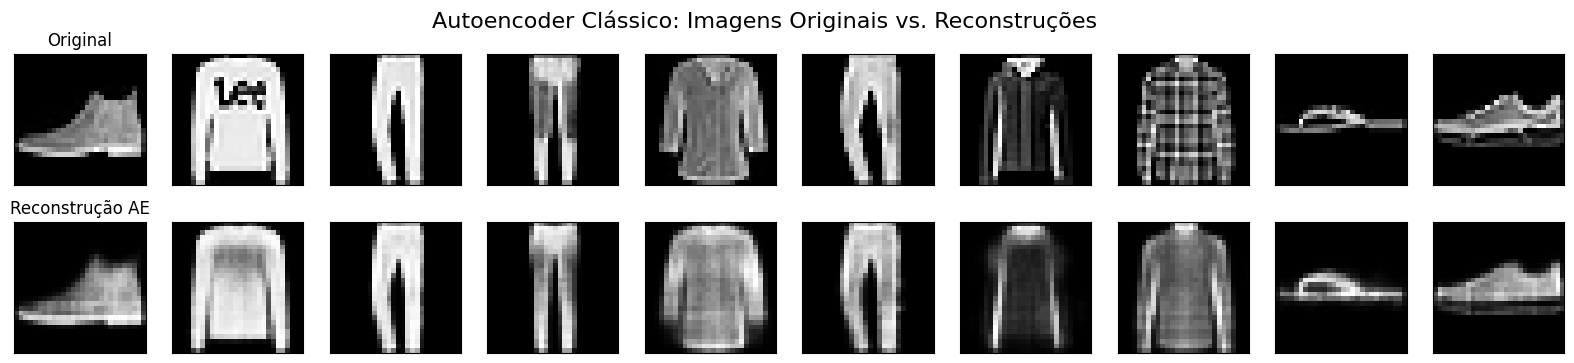

In [ ]:
# Gerar reconstruções para um subconjunto das imagens de teste
n = 10  # Número de imagens para mostrar
reconstructions_ae = autoencoder.predict(x_test_ae[:n])

plt.figure(figsize=(20, 4))
plt.suptitle('Autoencoder Clássico: Imagens Originais vs. Reconstruções', fontsize=16)

for i in range(n):
    # Imagem Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_ae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")

    # Reconstrução
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions_ae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstrução AE")

plt.show()

In [ ]:
# Camada de amostragem: Implementa o truque da reparametrização
class Sampling(layers.Layer):
    """
    Usa (z_mean, z_log_var) para amostrar z, o vetor latente.
    z = z_mean + exp(0.5 * z_log_var) * epsilon, onde epsilon ~ N(0, 1)
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Modelo VAE (herda de keras.Model para customizar o treinamento)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Método call é essencial para compatibilidade com model.fit
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z_mean)

    # Sobrescreve o método 'train_step' para incluir a perda KL
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # 1. Forward Pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 2. Perda de Reconstrução (Binary Cross-Entropy)
            reconstruction_loss = binary_crossentropy(data, reconstruction)
            reconstruction_loss *= ORIGINAL_DIM

            # 3. Perda de KL Divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # 4. Perda Total
            total_loss = reconstruction_loss + kl_loss

        # 5. Backward Pass
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 6. Atualização das Métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# --- Definição do Encoder VAE ---
inputs_vae = keras.Input(shape=(ORIGINAL_DIM,), name='encoder_input_vae')
x = layers.Dense(INTERMEDIATE_DIM, activation='relu')(inputs_vae)
z_mean = layers.Dense(LATENT_DIM_VAE, name='z_mean')(x)
z_log_var = layers.Dense(LATENT_DIM_VAE, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder_vae = keras.Model(inputs_vae, [z_mean, z_log_var, z], name='encoder_vae')

# --- Definição do Decoder VAE ---
latent_inputs_vae = keras.Input(shape=(LATENT_DIM_VAE,), name='z_sampling')
x = layers.Dense(INTERMEDIATE_DIM, activation='relu')(latent_inputs_vae)
outputs_vae = layers.Dense(ORIGINAL_DIM, activation='sigmoid', name='decoder_output_vae')(x)

decoder_vae = keras.Model(latent_inputs_vae, outputs_vae, name='decoder_vae')

# --- Instanciação do VAE ---
vae = VAE(encoder_vae, decoder_vae)
# CORREÇÃO: Adicionar uma perda 'dummy' (e.g., "mse") é obrigatório para a compilação.
# A perda real é calculada no método train_step.
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

print("--- Resumo do Encoder VAE ---")
encoder_vae.summary()
print("\n--- Resumo do Decoder VAE ---")
decoder_vae.summary()

--- Resumo do Encoder VAE ---


Model: "encoder_vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_vae   │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    200,960 │ encoder_input_va… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)


--- Resumo do Decoder VAE ---


Model: "decoder_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_vae (Dense)      │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS_VAE = 50 # Mais epochs são necessárias para o VAE
BATCH_SIZE_VAE = 128

print("Iniciando o treinamento do Variational Autoencoder (VAE)...")

history_vae = vae.fit(
    x_train_vae,
    epochs=EPOCHS_VAE,
    batch_size=BATCH_SIZE_VAE,
    shuffle=True,
    # Fornecer a entrada (x_test_vae) também como alvo (y_test) para validação,
    # pois VAEs são Autoencoders, e o modelo base do Keras espera um alvo não-nulo.
    validation_data=(x_test_vae, x_test_vae),
    verbose=2
)

print("\nTreinamento do VAE concluído.")

Iniciando o treinamento do Variational Autoencoder (VAE)...
Epoch 1/50
469/469 - 3s - 6ms/step - kl_loss: 6.4019 - loss: 280.2319 - reconstruction_loss: 273.8298 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/50
469/469 - 1s - 3ms/step - kl_loss: 6.2571 - loss: 276.0769 - reconstruction_loss: 269.8196 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/50
469/469 - 2s - 3ms/step - kl_loss: 6.2647 - loss: 273.2381 - reconstruction_loss: 266.9734 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/50
469/469 - 1s - 3ms/step - kl_loss: 6.2526 - loss: 271.3773 - reconstruction_loss: 265.1249 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/50
469/469 - 1s - 3ms/step - kl_loss: 6.2476 - loss: 270.2213 - reconstruction_loss: 263.9738 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


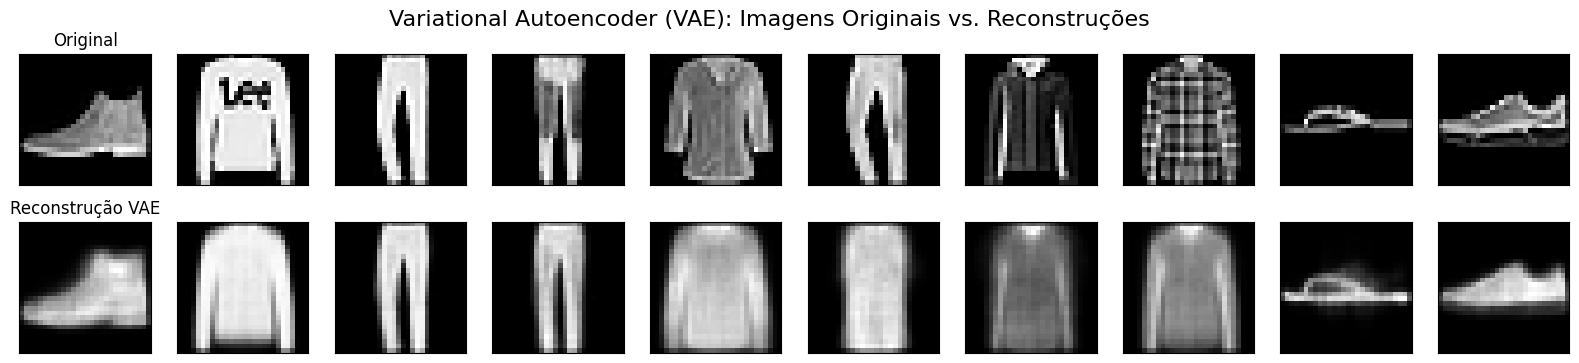

In [ ]:
# Gerar reconstruções para um subconjunto das imagens de teste
n = 10
# A função de predição do encoder retorna z_mean, z_log_var e z_amostrado. Pegamos o z_amostrado.
z_mean, _, z_vae = encoder_vae.predict(x_test_vae[:n], batch_size=BATCH_SIZE_VAE)
reconstructions_vae = decoder_vae.predict(z_vae)

plt.figure(figsize=(20, 4))
plt.suptitle('Variational Autoencoder (VAE): Imagens Originais vs. Reconstruções', fontsize=16)

for i in range(n):
    # Imagem Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_vae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")

    # Reconstrução VAE
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions_vae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstrução VAE")

plt.show()

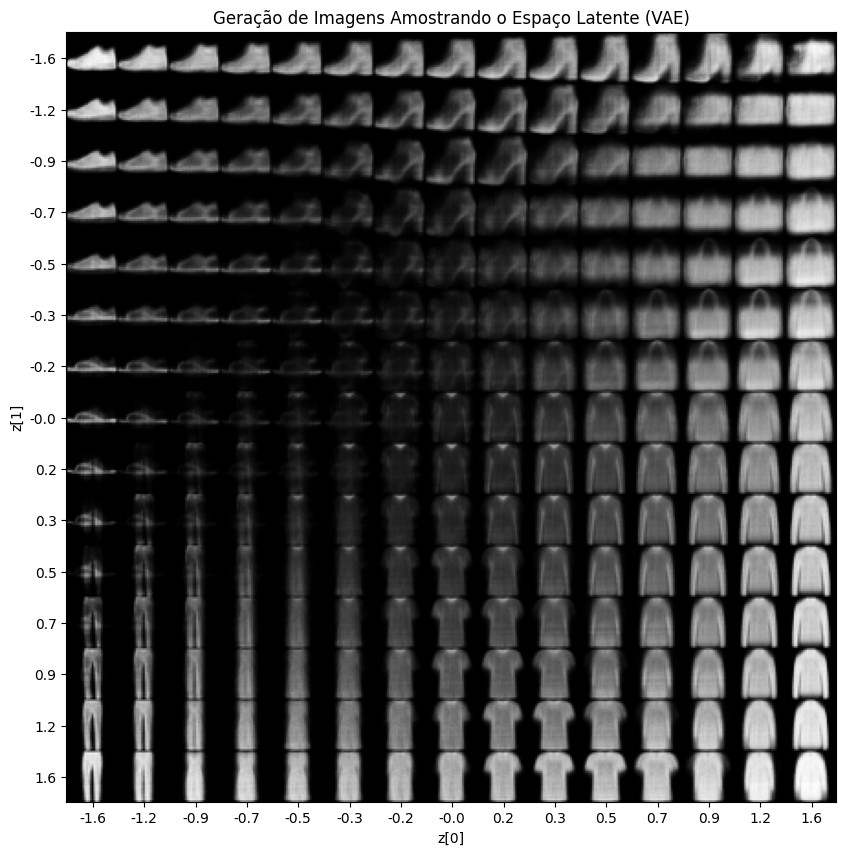

In [ ]:
# Plotar uma grade de imagens geradas
n = 15  # 15x15 imagens
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Amostrar do espaço latente 2D (que é uma Gaussiana padrão)
# Criamos um grid no intervalo [-1.5, 1.5] para amostragem no espaço latente
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Amostrar um ponto (zi, zj) no espaço latente 2D
        z_sample = np.array([[xi, yi]])
        # Decodificar o ponto latente
        x_decoded = decoder_vae.predict(z_sample, verbose=0)
        # Reformatar para imagem 28x28
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Colocar a imagem na grade
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('Geração de Imagens Amostrando o Espaço Latente (VAE)')

# CÁLCULO: Garantir que o número de ticks (15) seja igual ao número de rótulos (15)
start_range = digit_size // 2
# REMOVER o + 1 extra para que np.arange retorne exatamente N elementos
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

# As chamadas a seguir agora terão (15 ticks, 15 labels)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


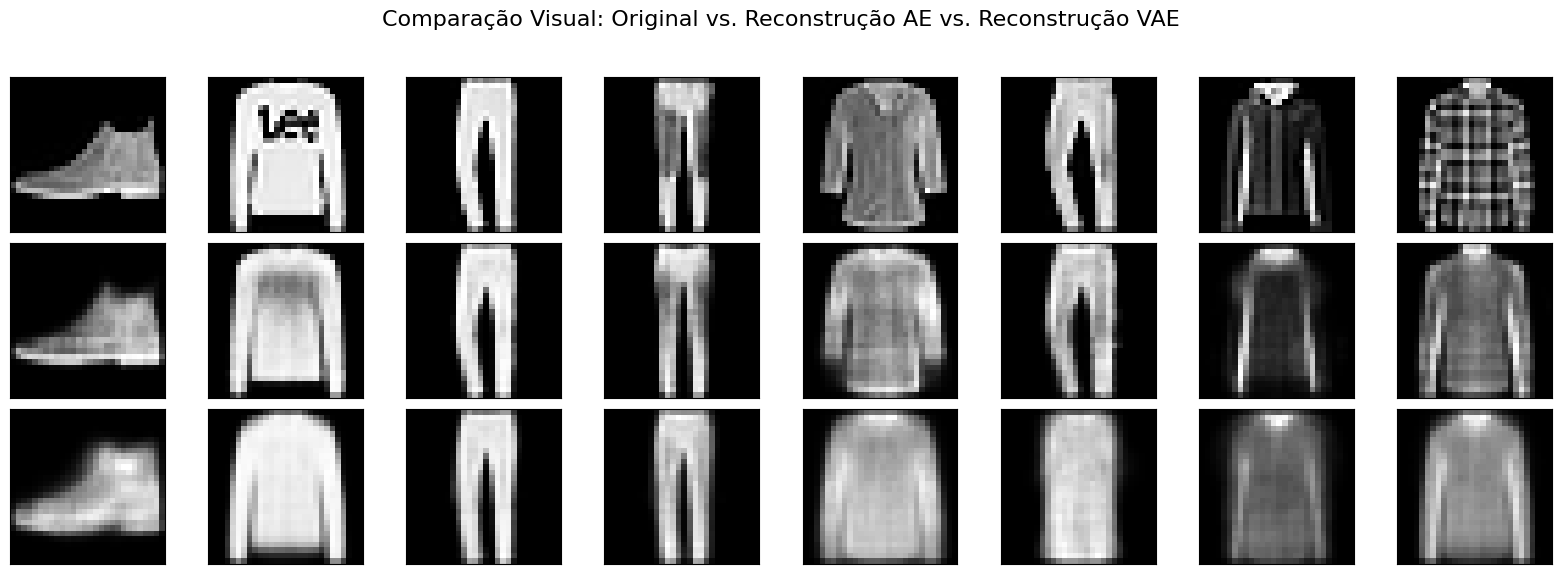

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


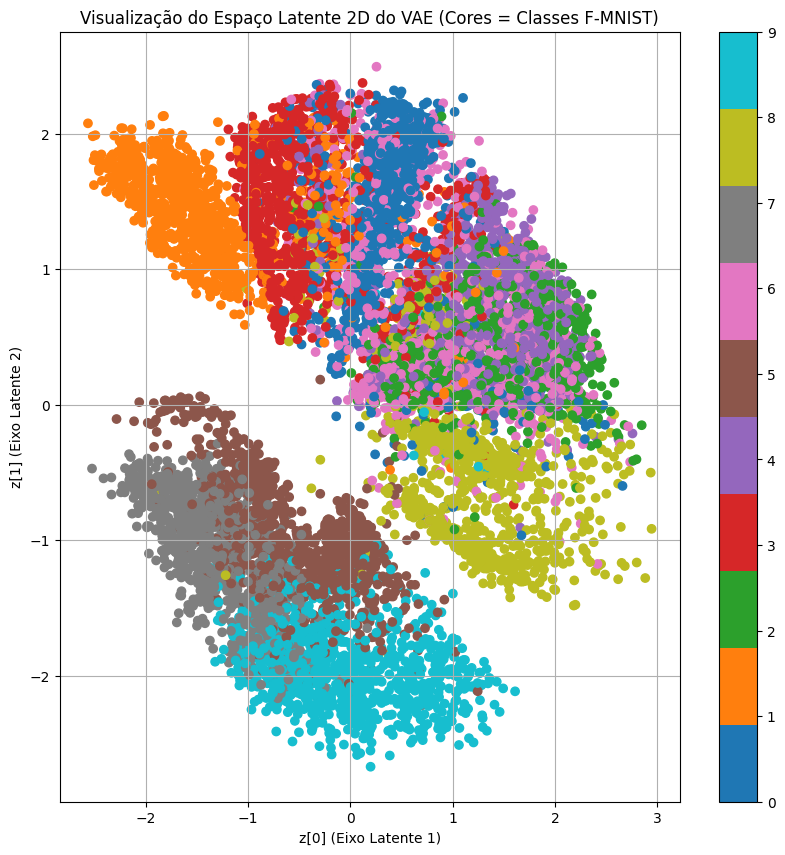

In [ ]:
# Amostrar algumas imagens de teste
n = 8
imgs = x_test_ae[:n]

# 1. Reconstruções do Autoencoder Clássico (AE)
reconstructions_ae = autoencoder.predict(imgs)

# 2. Reconstruções do Variational Autoencoder (VAE)
z_mean, _, z_vae = encoder_vae.predict(imgs)
reconstructions_vae = decoder_vae.predict(z_mean) # Usamos z_mean aqui para reconstrução determinística

# 3. Plotagem
plt.figure(figsize=(16, 6))
plt.suptitle('Comparação Visual: Original vs. Reconstrução AE vs. Reconstrução VAE', fontsize=16)

for i in range(n):
    # Imagem Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_ylabel("Original", fontsize=12)

    # Reconstrução AE
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructions_ae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_ylabel("Reconstrução AE", fontsize=12)

    # Reconstrução VAE
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(reconstructions_vae[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_ylabel("Reconstrução VAE", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para o suptitle
plt.show()

# --- Visualização do Espaço Latente 2D do VAE ---
# Codificar todas as imagens de teste
z_mean, _, _ = encoder_vae.predict(x_test_vae, batch_size=BATCH_SIZE_VAE)

plt.figure(figsize=(10, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10') # Usa os rótulos y_test como cor
plt.colorbar()
plt.xlabel("z[0] (Eixo Latente 1)")
plt.ylabel("z[1] (Eixo Latente 2)")
plt.title("Visualização do Espaço Latente 2D do VAE (Cores = Classes F-MNIST)")
plt.grid()
plt.show()